#### Importing Dependencies

In [124]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import wordnet
import re
import nltk
from nltk.corpus import stopwords
from IPython.core.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')
import ast # to convert a string list into a list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Linking to Google Colab to The Diver & Getting the Dataset 

In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv("/content/drive/My Drive/jobs_data.csv")

#### Data Cleaning

**The "JobTitle Cleaning"**, First we remove the punctuation, numbers, non-English characters and stop words (words like a,the,...,etc) from each job title, then all the words are converted to lower case, then stemmed using the Porter Stemmer in the NLTK package. The goal of stemming is to reduce the number of inflectional forms of words appearing in the title; it will cause words such as “developer” and “developing” into syntactically match one another by reducing them to their base word “develop”. This helps decrease the size of the vocabulary space and improve the volume of the feature space in the corpus. And finally, each corpus is transformed into vector space model (VSM) using the tf-idf vectorizer in Python’s SKlearn package to extract the features.

In [0]:
stemmer = PorterStemmer()
words = stopwords.words("english")
df['title'] = df['title'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [128]:
df.head()

,Unnamed: 0,title,jobFunction,industry
0,0,full stack php develop,"['Engineering - Telecom/Technology', 'IT/Softw...","['Computer Software', 'Marketing and Advertisi..."
1,1,cisco collabor specialist engin,"['Installation/Maintenance/Repair', 'IT/Softwa...",['Information Technology Services']
2,2,senior back end php develop,"['Engineering - Telecom/Technology', 'IT/Softw...","['Computer Software', 'Computer Networking']"
3,3,ux design,"['Creative/Design/Art', 'IT/Software Developme...","['Computer Software', 'Information Technology ..."
4,4,java technic lead,"['Engineering - Telecom/Technology', 'IT/Softw...","['Computer Software', 'Information Technology ..."


**The jobFunction Cleaning** First as every element in this column is a string we convert it to list, then we starting cleaning it just like the jobTitle by removing the punctuation, numbers and stop words (words like a,the,...,etc) from each job function (only if there are found).  

In [129]:
df['jobFunction']= df['jobFunction'].apply(ast.literal_eval).apply(np.sort)
df.head()

,Unnamed: 0,title,jobFunction,industry
0,0,full stack php develop,"[Engineering - Telecom/Technology, IT/Software...","['Computer Software', 'Marketing and Advertisi..."
1,1,cisco collabor specialist engin,"[Engineering - Telecom/Technology, IT/Software...",['Information Technology Services']
2,2,senior back end php develop,"[Engineering - Telecom/Technology, IT/Software...","['Computer Software', 'Computer Networking']"
3,3,ux design,"[Creative/Design/Art, IT/Software Development]","['Computer Software', 'Information Technology ..."
4,4,java technic lead,"[Engineering - Telecom/Technology, IT/Software...","['Computer Software', 'Information Technology ..."


In [130]:
df_no_industry = df.ix[:,(1,2)]
display(HTML(df_no_industry.to_html())) # print the whole dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]


,title,jobFunction
0,full stack php develop,"[Engineering - Telecom/Technology, IT/Software Development]"
1,cisco collabor specialist engin,"[Engineering - Telecom/Technology, IT/Software Development, Installation/Maintenance/Repair]"
2,senior back end php develop,"[Engineering - Telecom/Technology, IT/Software Development]"
3,ux design,"[Creative/Design/Art, IT/Software Development]"
4,java technic lead,"[Engineering - Telecom/Technology, IT/Software Development]"
5,technic support engin,"[Customer Service/Support, Engineering - Telecom/Technology, IT/Software Development]"
6,senior io develop,"[Engineering - Telecom/Technology, IT/Software Development]"
7,mechan engin,[Engineering - Mechanical/Electrical]
8,real estat sale specialist th ramadan,[Sales/Retail]
9,school princip,"[Administration, Education/Teaching, Operations/Management]"


In [131]:
df_no_industry = df_no_industry.sort_values(by='title')
df_no_industry.head()

,title,jobFunction
2290,,[Sales/Retail]
10629,,[Sales/Retail]
1668,,"[Marketing/PR/Advertising, Media/Journalism/Pu..."
7607,,[Sales/Retail]
136,,[Education/Teaching]


Getting red of The nan (empty) rows

In [132]:
def jobFunctionClean(x):
  flat_list = []
  for sublist in x:
    for item in sublist:
      item = item.replace(" " , "")
      item = item.replace("/" , "")
      item = item.replace("-" , "")
      if(item !='nan'):
        flat_list.append(item)
  return list(dict.fromkeys(flat_list))

df_no_industry = df_no_industry.groupby('title').jobFunction.apply(list).reset_index()
df_no_industry['jobFunction'] = df_no_industry['jobFunction'].apply(jobFunctionClean)
df_no_industry = df_no_industry[df_no_industry['jobFunction'].map(lambda d: len(d)) > 0].reset_index()
df_no_industry = df_no_industry[df_no_industry['title'].map(lambda d: len(d)) > 0].reset_index()

#display(HTML(df_no_industry.to_html()))
df_no_industry.head()

,level_0,index,title,jobFunction
0,1,2,abap consult,"[EngineeringTelecomTechnology, ITSoftwareDevel..."
1,2,3,account,"[AccountingFinance, Administration, HumanResou..."
2,3,4,account account payabl,[AccountingFinance]
3,4,5,account account receiv,[AccountingFinance]
4,5,6,account alexandria,[AccountingFinance]


#### Testing & Preparing Data for the Classifier

In [133]:
function = list(df_no_industry['jobFunction'])
classes = [] 
for i in function:
  for x in i:
    classes.append(x)
    classes = list(set(classes))
print("number of classes : ", len(classes))
print("classes: ", classes)

number of classes :  37
classes:  ['CustomerServiceSupport', 'EducationTeaching', 'HumanResources', 'WritingEditorial', 'MediaJournalismPublishing', 'EngineeringConstructionCivilArchitecture', 'EngineeringOil&GasEnergy', 'TourismTravel', 'MedicalHealthcare', 'InstallationMaintenanceRepair', 'AnalystResearch', 'ITSoftwareDevelopment', 'SportsandLeisure', 'EngineeringOther', 'BusinessDevelopment', 'HospitalityHotelsFoodServices', 'EngineeringTelecomTechnology', 'TrainingInstructor', 'PurchasingProcurement', 'ManufacturingProduction', 'EngineeringMechanicalElectrical', 'CLevelExecutiveGMDirector', 'Fashion', 'OperationsManagement', 'CreativeDesignArt', 'Quality', 'Pharmaceutical', 'SalesRetail', 'AccountingFinance', 'LogisticsSupplyChain', 'Legal', 'Banking', 'Administration', 'StrategyConsulting', 'R&DScience', 'MarketingPRAdvertising', 'ProjectProgramManagement']


In [134]:
title = list(df_no_industry.title)
print(title)
print(len(title))

['abap consult', 'account', 'account account payabl', 'account account receiv', 'account alexandria', 'account associ', 'account cairo', 'account construct', 'account consult', 'account coordin', 'account develop corpor sale b b horeca', 'account execut', 'account execut advertis', 'account execut btl', 'account execut btl advertis agenc', 'account furnitur factori', 'account intern', 'account internship', 'account manag', 'account manag advertis', 'account manag advertis agenc', 'account manag assist', 'account manag cairo', 'account manag intern', 'account manag ksa', 'account payabl account', 'account payabl specialist', 'account qalubia', 'account real estat cairo egypt', 'account real estat th settlement', 'account receiv', 'account receiv account', 'account receiv specialist', 'account sap user', 'account section head', 'account tanta', 'account tourism', 'activ teacher foreign', 'admin', 'admin assist', 'admin assist heliopoli', 'admin assist offic manag', 'admin assist sheikh z

In [135]:
print(function) 
len(function)

[['EngineeringTelecomTechnology', 'ITSoftwareDevelopment', 'StrategyConsulting'], ['AccountingFinance', 'Administration', 'HumanResources'], ['AccountingFinance'], ['AccountingFinance'], ['AccountingFinance'], ['CustomerServiceSupport', 'SalesRetail'], ['AccountingFinance'], ['AccountingFinance'], ['AccountingFinance'], ['Administration', 'CustomerServiceSupport'], ['SalesRetail'], ['MarketingPRAdvertising', 'SalesRetail', 'CustomerServiceSupport', 'ITSoftwareDevelopment', 'CreativeDesignArt', 'Pharmaceutical'], ['MarketingPRAdvertising', 'SalesRetail'], ['MarketingPRAdvertising', 'MediaJournalismPublishing'], ['CustomerServiceSupport', 'MarketingPRAdvertising', 'SalesRetail'], ['AccountingFinance'], ['AccountingFinance'], ['AccountingFinance'], ['BusinessDevelopment', 'AccountingFinance', 'MarketingPRAdvertising', 'MediaJournalismPublishing', 'SalesRetail', 'CustomerServiceSupport'], ['SalesRetail'], ['MarketingPRAdvertising', 'MediaJournalismPublishing'], ['Administration', 'Customer

3053

In [136]:
col = ['title']
col = col + classes
mul_labels_df = pd.DataFrame(columns=col)
mul_labels_df.title = df_no_industry.title
df_no_industry.iloc[1]['jobFunction']
for i in range(len(df_no_industry.jobFunction)) :
  j = df_no_industry.jobFunction[i]
  for e in j:
    mul_labels_df.iloc[i][e] = 1

mul_labels_df = mul_labels_df.fillna(0)
mul_labels_df.head()

,title,CustomerServiceSupport,EducationTeaching,HumanResources,WritingEditorial,MediaJournalismPublishing,EngineeringConstructionCivilArchitecture,EngineeringOil&GasEnergy,TourismTravel,MedicalHealthcare,InstallationMaintenanceRepair,AnalystResearch,ITSoftwareDevelopment,SportsandLeisure,EngineeringOther,BusinessDevelopment,HospitalityHotelsFoodServices,EngineeringTelecomTechnology,TrainingInstructor,PurchasingProcurement,ManufacturingProduction,EngineeringMechanicalElectrical,CLevelExecutiveGMDirector,Fashion,OperationsManagement,CreativeDesignArt,Quality,Pharmaceutical,SalesRetail,AccountingFinance,LogisticsSupplyChain,Legal,Banking,Administration,StrategyConsulting,R&DScience,MarketingPRAdvertising,ProjectProgramManagement
0,abap consult,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,account,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,account account payabl,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,account account receiv,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,account alexandria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


#### WordCloud Representation

WordCloud representation of most used words that would lead classifier to HumanResources. (for example to get to understant the data better) 

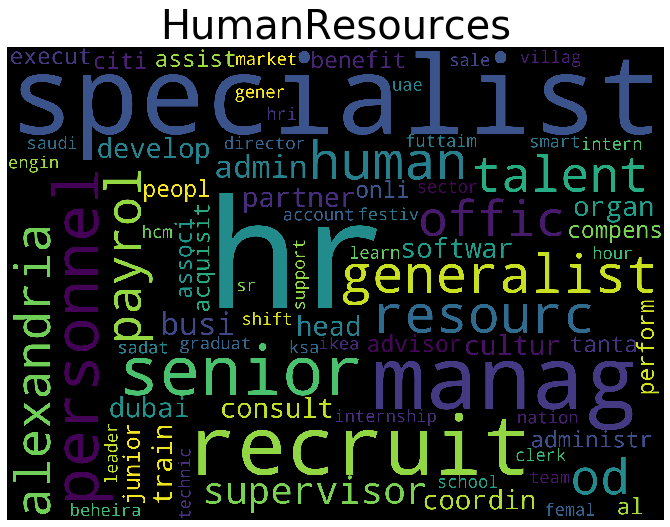

In [137]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(40,25))

# toxic
subset = mul_labels_df[mul_labels_df.HumanResources==1]
text = subset.title.values
cloud_HumanResources = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 1)
plt.axis('off')
plt.title("HumanResources",fontsize=40)
plt.imshow(cloud_HumanResources)


#### Building and Training Classifier 

In [138]:
data = mul_labels_df
data = mul_labels_df.loc[np.random.choice(mul_labels_df.index, size=3050)]
data.shape

(3050, 38)

In [0]:
data.to_csv(r'/content/drive/My Drive/cleaned_data.csv', index=False) # download the cleaned data

In [140]:
data.head()

,title,CustomerServiceSupport,EducationTeaching,HumanResources,WritingEditorial,MediaJournalismPublishing,EngineeringConstructionCivilArchitecture,EngineeringOil&GasEnergy,TourismTravel,MedicalHealthcare,InstallationMaintenanceRepair,AnalystResearch,ITSoftwareDevelopment,SportsandLeisure,EngineeringOther,BusinessDevelopment,HospitalityHotelsFoodServices,EngineeringTelecomTechnology,TrainingInstructor,PurchasingProcurement,ManufacturingProduction,EngineeringMechanicalElectrical,CLevelExecutiveGMDirector,Fashion,OperationsManagement,CreativeDesignArt,Quality,Pharmaceutical,SalesRetail,AccountingFinance,LogisticsSupplyChain,Legal,Banking,Administration,StrategyConsulting,R&DScience,MarketingPRAdvertising,ProjectProgramManagement
1165,junior network engin,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
360,content creator develop,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2299,senior gener account,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3029,web develop front end back end,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1197,key account sale supervisor,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [141]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)

print(train.shape)
print(test.shape)

(2135, 38)
(915, 38)


In [0]:
train_text = train['title']
test_text = test['title']

Word Frequencies with TfidfVectorizer
This is an acronym than stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word. Term Frequency: This summarizes how often a given word appears within a document.

In [143]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['title'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['title'], axis=1)

In [145]:
pip install scikit-multilearn

In [0]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)


#### Saving Final Model 

In [0]:
from sklearn.externals import joblib

filename = '/content/drive/My Drive/finalized_model.sav'
joblib.dump(classifier, filename)

#### Model Evaluadtion 

Model evaludation done by calculating The model's Accuracy, Precision, Recall and F1score

In [147]:
from sklearn.metrics import recall_score , f1_score ,precision_score,accuracy_score

print("Accuracy = ",accuracy_score(y_test,predictions))
print(' recall is : ' , recall_score (y_test, predictions, average='macro'))
print(' precision is : ' , precision_score(y_test, predictions, average='macro'))
print(' f1 Score is : ' , f1_score(y_test, predictions, average='macro') )

Accuracy =  0.6688524590163935
 recall is :  0.7353969559651408
 precision is :  0.5315918642846755
 f1 Score is :  0.6062812685293669


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Final Testing

In [0]:
mapper = []
for i in data.columns :
  if i == "title" :
    continue
  else: 
    mapper.append(i)

In [0]:
example = "hr specialist"
vec_example = vectorizer.transform([example , "-"])

In [157]:
predic = classifier.predict(vec_example)
output = predic.toarray(order = {2})
print(output[0])

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


In [0]:
predicted_jobfunctions = []
for i in range(0,len(mapper)):
  if output[0][i] == 0 :
    continue
  else :
     predicted_jobfunctions.append(mapper[i])

In [159]:
for i in predicted_jobfunctions:
  print(i)

HumanResources
Administration
